# Binary lung classifier

In [ ]:
import os
import pandas as pd
from datetime import datetime

In [ ]:
all_files = os.listdir("audios")

# Count .webm files
webm_files = [f for f in all_files if f.endswith('.webm')]
num_webm = len(webm_files)

# Search for the CSV
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
num_csv = len(csv_files)

print(f"Total de archivos .webm: {num_webm}")
print(f"Total de archivos .csv: {num_csv}")
print(f"Archivo CSV encontrado: {csv_files[0] if csv_files else 'No encontrado'}")

Total de archivos .webm: 1445
Total de archivos .csv: 0
Archivo CSV encontrado: No encontrado


In [ ]:
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

In [ ]:
from huggingface_hub import from_pretrained_keras

# Load the model directly from Hugging Face Hub
loaded_model = from_pretrained_keras("google/hear")
# Inference function for embedding generation
infer = loaded_model.signatures["serving_default"]

Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import re
import pickle

# Cargar los embeddings desde archivo
with open("audium_embeddings.pkl", "rb") as f:
    file_embeddings = pickle.load(f)

# Cargar el CSV original
df = pd.read_csv("Audium_Multilab_Covid_Master.csv")

# Filtrar registros válidos
df_valid = df[df["Valid"] == "Yes"].copy()

# Regenerar los códigos únicos
def generate_code(row):
    date_str = pd.to_datetime(row["Date"]).strftime("%Y%m%d")
    time_str = pd.to_datetime(row["Time"]).strftime("%H%M%S")
    code = row["Code"]
    filename = row["Filename"]
    return f"{date_str}{time_str}_{code}{filename}".replace(" ", "%20")

df_valid["Generated_Code"] = df_valid.apply(generate_code, axis=1)

# Filtrar por los que sí tienen embeddings
df_valid = df_valid[df_valid["Generated_Code"].isin(file_embeddings)]

# Etiquetar como binario: 1 si menciona "clear lung sound(s)", 0 si no
df_valid["Label"] = df_valid["Comment"].str.contains(r"clear lung sound[s]?", flags=re.IGNORECASE, na=False).astype(int)

# Mostrar resumen
print("✅ Label distribution:")
print(df_valid["Label"].value_counts())

print("\n🔎 Ejemplos etiquetados con Label = 1:")
print(df_valid[df_valid["Label"] == 1][["Generated_Code", "Comment", "Label"]])

print(f"\n✅ Total registros válidos con embeddings: {len(df_valid)}")

✅ Label distribution:
Label
0    667
1    388
Name: count, dtype: int64

🔎 Ejemplos etiquetados con Label = 1:
                               Generated_Code  \
1     20230424140556_GB%20fe-1_lungfront.webm   
2      20230424140556_GB%20fe-1_lungback.webm   
10    20230424134952_LY%20fe-1_lungfront.webm   
22    20230424111328_RB%20fe-1_lungfront.webm   
23     20230424111328_RB%20fe-1_lungback.webm   
...                                       ...   
1607      20211207054534_ACD-D4_lungback.webm   
1609     20211207054333_ACW-D3_lungfront.webm   
1610      20211207054333_ACW-D3_lungback.webm   
1612  20211207054053_ACW-%20D2_lungfront.webm   
1613   20211207054053_ACW-%20D2_lungback.webm   

                                                Comment  Label  
1               Clear lung sounds with static artifacts      1  
2               Clear lung sounds with static artifacts      1  
10    Clear lung sounds with some artifacts. Clear h...      1  
22         Clear lung sounds with some s

<ipython-input-27-1412947158>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Label"] = df_valid["Comment"].str.contains(r"clear lung sound[s]?", flags=re.IGNORECASE, na=False).astype(int)


In [ ]:
import numpy as np

# Asegurar orden y consistencia entre df_valid y los embeddings
ordered_codes = df_valid["Generated_Code"].values

# Verificar que todas las claves existen en el diccionario
missing = [code for code in ordered_codes if code not in file_embeddings]
print(f"🔍 Missing keys: {len(missing)}")  # debería ser 0 si hiciste .isin antes

# Crear embeddings promedio por archivo
embeddings_avg = np.array([file_embeddings[code].mean(axis=0) for code in ordered_codes])

# Verificar dimensiones
print(f"✅ embeddings_avg shape: {embeddings_avg.shape}")

🔍 Missing keys: 0
✅ embeddings_avg shape: (1055, 512)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Definir modelos
models = {
    "Support Vector Machine (linear)": SVC(kernel='linear', probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),  # ya da probabilidad
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=128),  # ya da
    "Random Forest": RandomForestClassifier(n_estimators=128),  # ya da
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000),  # ya da
}

results = []

for name, model in models.items():
    print(f"\n🧪 Modelo: {name}")
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "Predictions": preds  # Por si necesitas graficar después
    })


🧪 Modelo: Support Vector Machine (linear)

🧪 Modelo: Logistic Regression

🧪 Modelo: Gradient Boosting

🧪 Modelo: Random Forest

🧪 Modelo: MLP Classifier


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Reconstruir model_predictions y true_labels
model_predictions = {r["Model"]: r["Predictions"] for r in results}
true_labels = y_test.tolist()  # y_test es el real, ya existe

# 2. Crear tabla de métricas extendida
rows = []
for model_name, predictions in model_predictions.items():
    labels = sorted(set(true_labels + list(predictions)))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    TP = np.diag(cm)
    FN = np.sum(cm, axis=1) - TP
    FP = np.sum(cm, axis=0) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    sensitivity = TP / (TP + FN + 1e-10)
    specificity = TN / (TN + FP + 1e-10)
    precision = TP / (TP + FP + 1e-10)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-10)
    accuracy = accuracy_score(true_labels, predictions)
    support = np.sum(cm, axis=1)

    for i, label in enumerate(labels):
        rows.append({
            "Modelo": model_name,
            "Clase": "clear lung" if label == 1 else "other",
            "Precision": round(precision[i], 2),
            "Recall (Sensibilidad)": round(sensitivity[i], 2),
            "Specificity": round(specificity[i], 2),
            "F1 Score": round(f1[i], 2),
            "Accuracy Global": round(accuracy, 2),
            "Support": int(support[i])
        })

# 3. Mostrar tabla con estilo visual
df_metrics = pd.DataFrame(rows)

df_metrics.style.background_gradient(
    subset=["Precision", "Recall (Sensibilidad)", "Specificity", "F1 Score", "Accuracy Global"],
    cmap="YlGn"
).format(precision=2)

,Modelo,Clase,Precision,Recall (Sensibilidad),Specificity,F1 Score,Accuracy Global,Support
0,Support Vector Machine (linear),other,0.87,0.86,0.78,0.87,0.83,133
1,Support Vector Machine (linear),clear lung,0.77,0.78,0.86,0.78,0.83,78
2,Logistic Regression,other,0.91,0.88,0.85,0.89,0.87,133
3,Logistic Regression,clear lung,0.80,0.85,0.88,0.82,0.87,78
4,Gradient Boosting,other,0.94,0.91,0.90,0.92,0.91,133
5,Gradient Boosting,clear lung,0.85,0.90,0.91,0.87,0.91,78
6,Random Forest,other,0.90,0.90,0.83,0.90,0.88,133
7,Random Forest,clear lung,0.83,0.83,0.90,0.83,0.88,78
8,MLP Classifier,other,0.89,0.89,0.82,0.89,0.86,133
9,MLP Classifier,clear lung,0.81,0.82,0.89,0.82,0.86,78


Comparing models per class, we observe that Gradient Boosting presents the greatest general stability, with high values ​​in sensitivity, precision and F1 Score. Other models such as SVM or MLP tend to have good performance in negative classes (‘other’), but less recall in ‘Clear Lung’. This indicates that some positive cases could be ignored.


📊 Evaluación del modelo: Logistic Regression


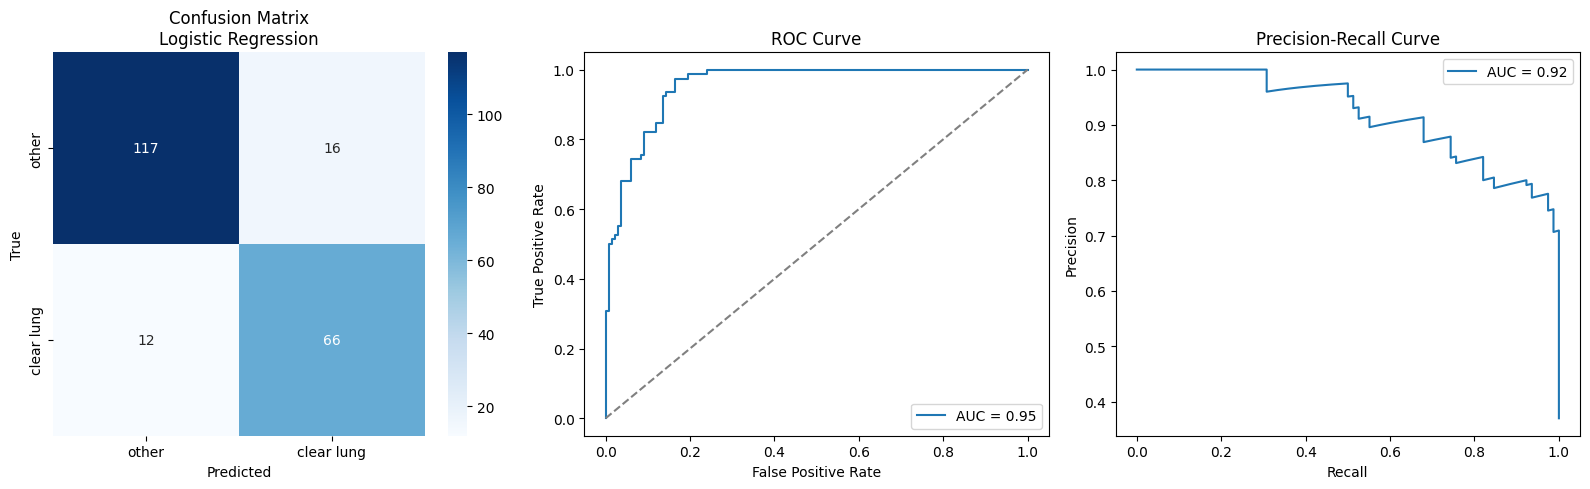


📊 Evaluación del modelo: Random Forest


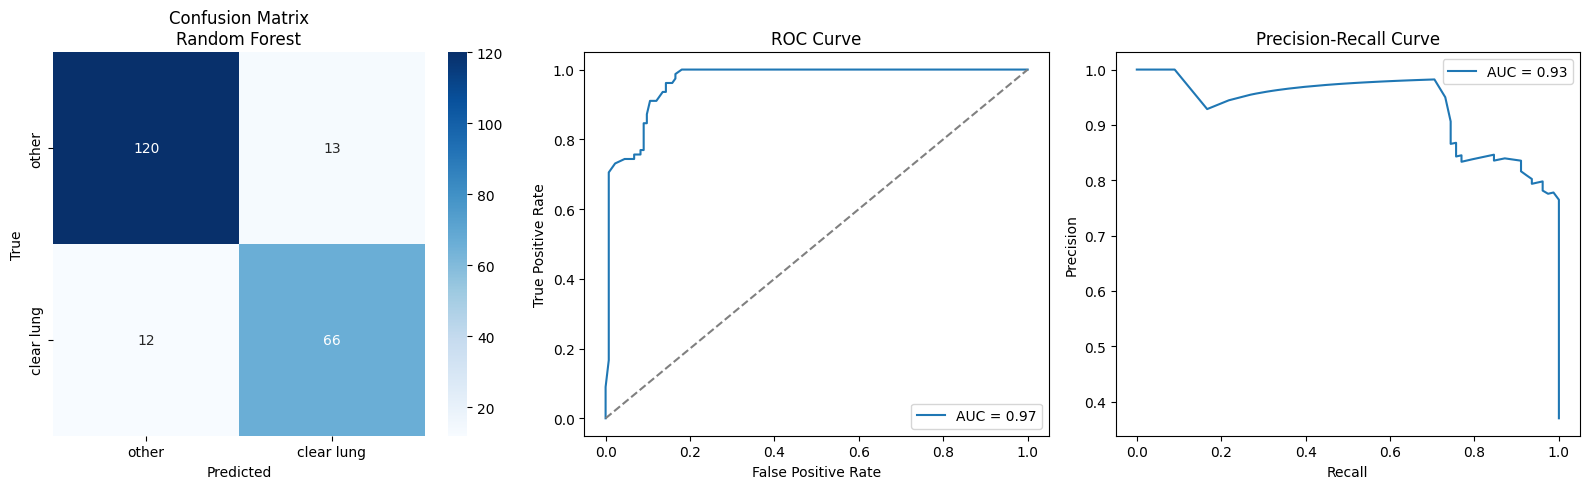


📊 Evaluación del modelo: Gradient Boosting


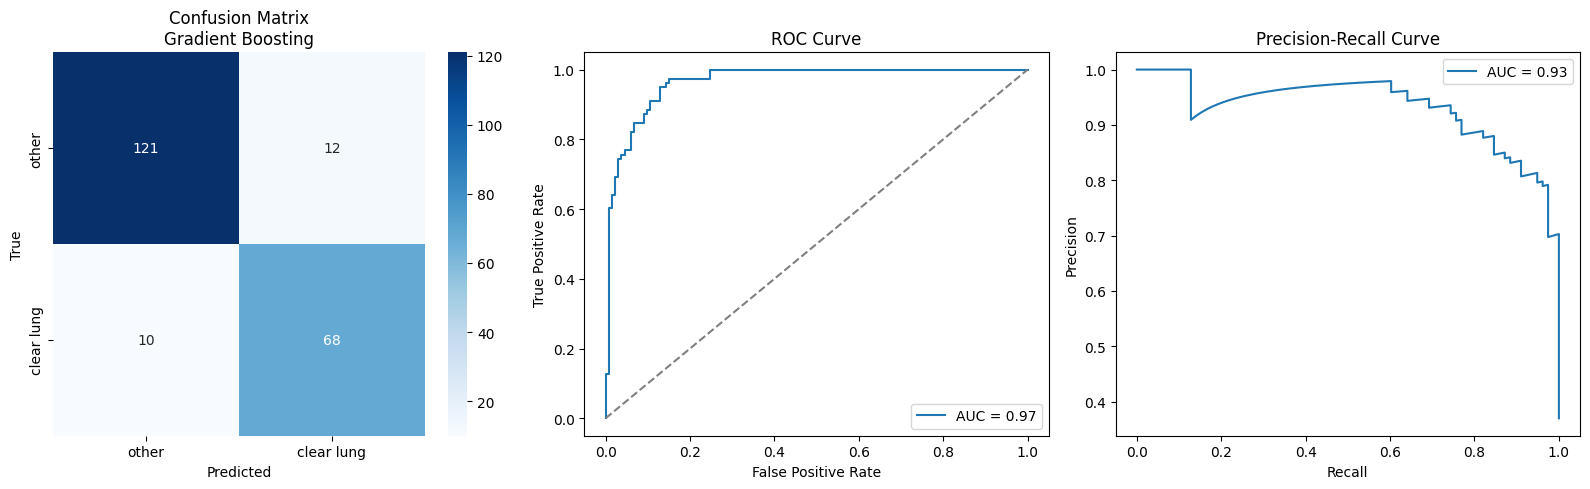


📊 Evaluación del modelo: SVM


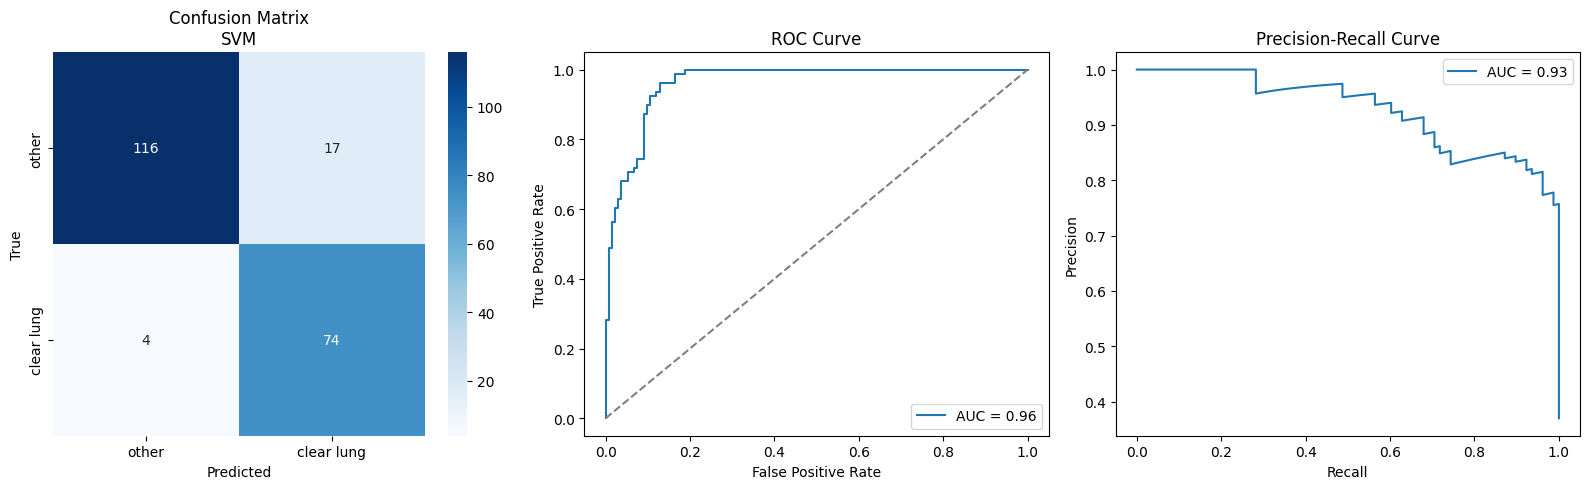


📊 Evaluación del modelo: MLP Classifier


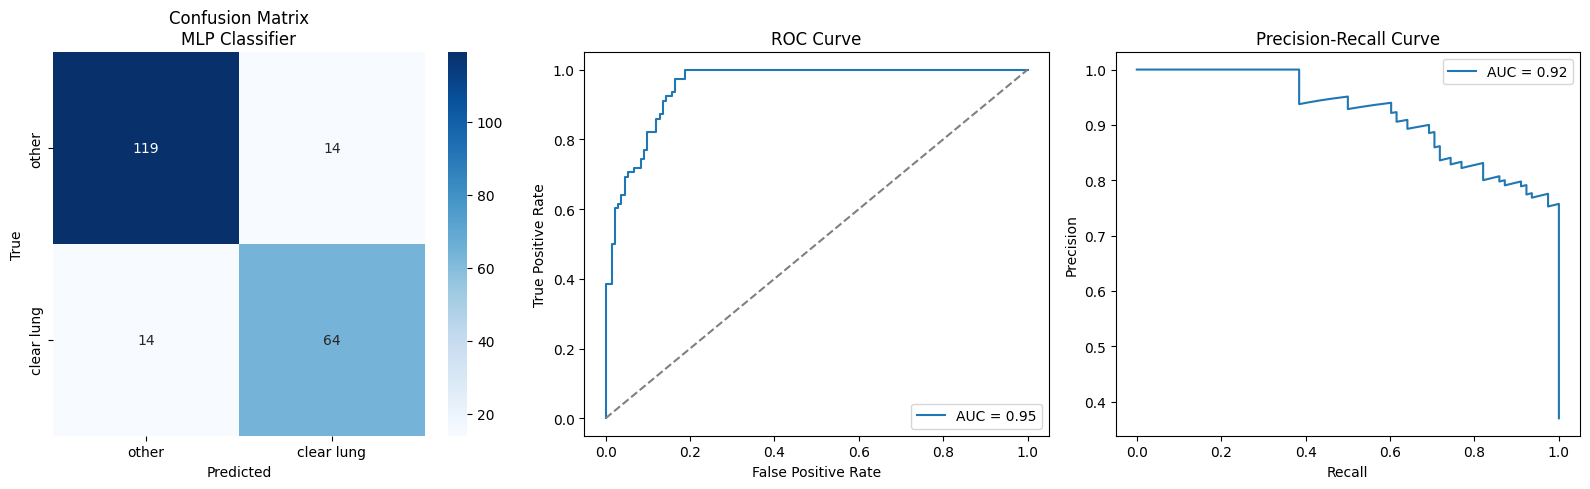

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import numpy as np

def plot_confusion_matrix_and_curves(models, X_test, y_test):
    for name, model in models.items():
        print(f"\n📊 Evaluación del modelo: {name}")

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(16, 5))

        plt.subplot(1, 3, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["other", "clear lung"], yticklabels=["other", "clear lung"])
        plt.title(f"Confusion Matrix\n{name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.subplot(1, 3, 2)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gxray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        plt.subplot(1, 3, 3)
        plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

plot_confusion_matrix_and_curves(models, X_test_scaled, y_test)

📊 Evaluation Summary

The classification results for clear lung sounds vs. other recordings show strong and consistent performance across all evaluated models. Key observations include:

1. Confusion Matrix
- All models demonstrate low error rates, with a small number of false positives and false negatives.
- For instance, Logistic Regression correctly classified 117 out of 133 “other” recordings and 66 out of 78 “clear lung” recordings.

2. ROC Curve
- The ROC curves are sharply curved toward the top-left corner, with AUC scores ranging from 0.95 to 0.97.
- This indicates excellent discrimination capability between the two classes.

3. Precision-Recall Curve
- Precision-Recall curves also show strong performance, with AUC values between 0.92 and 0.93.
- This suggests the models maintain high precision without sacrificing recall, even in the presence of class imbalance.

All models perform well, but Gradient Boosting and Random Forest stand out with balanced and high scores across all metrics. This notebook demonstrates a reliable and interpretable pipeline for detecting clear lung sounds using averaged embeddings and standard classifiers, with well-calibrated confidence outputs supported by the ROC and PR curves.
